In [4]:
import pickle
import numpy as np
import tensorflow.keras.utils

X_train= pickle.load(open("Datasets/binaryFormNorm/X_train.pickle","rb"))
y_train = pickle.load(open("Datasets/binaryFormNorm/y_train.pickle","rb"))

In [5]:
X_train=X_train/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


NAME= "2BinaryNormCanc-64-32-2"
EarlyStop=EarlyStopping(patience=5,monitor='val_loss')
checkpoints=ModelCheckpoint(filepath=f'ModelCheckPoints/{NAME}.h5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='DeepModels/{}'.format(NAME))
callbacks=[EarlyStop,checkpoints,tensorboard]
model = Sequential()
model.add(Conv2D(64, (2,2), input_shape = X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (2,2)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 249, 249, 64)      832       
_________________________________________________________________
activation_4 (Activation)    (None, 249, 249, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 123, 123, 32)      8224      
_________________________________________________________________
activation_5 (Activation)    (None, 123, 123, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 16)       

In [7]:
history=model.fit(X_train,y_train,batch_size=32,validation_split=0.2,epochs=15,callbacks=[callbacks])

Epoch 1/15
97/97 [==============================] - 14s 74ms/step - loss: 0.4757 - accuracy: 0.7705 - val_loss: 0.4047 - val_accuracy: 0.8119

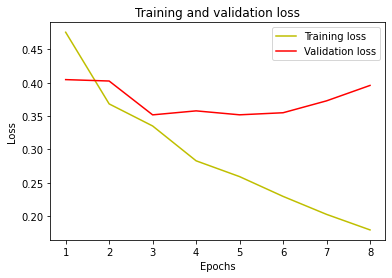

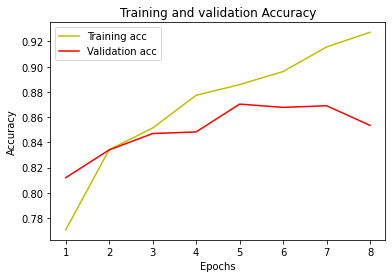

In [9]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss,'y', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,'y', label = "Training acc")
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title("Training and validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
from tensorflow.keras.models import load_model
model=load_model("ModelCheckPoints/2BinaryNormCanc-64-32-2.h5")

In [19]:
import pickle
X_test=pickle.load(open("Datasets/binaryFormNorm/X_test.pickle","rb"))
y_test=pickle.load(open("Datasets/binaryFormNorm/y_test.pickle","rb"))
X_test=X_test/255.
y_test=tensorflow.keras.utils.to_categorical(y_test)


In [20]:
_,acc = model.evaluate(X_test,y_test)
print("Accuracy = ", (acc*100.0), "%")


31/31 [==============================] - 1s 21ms/step - loss: 0.2979 - accuracy: 0.8600
Accuracy =  85.

In [21]:
CAT=['BenignOrCancer','Normal']
# my_threshold=0.5
from sklearn.metrics import confusion_matrix
# y_pred=(model.predict(X_test)>my_threshold).astype(int)
# CAT=['CancerOrBenign','Normal']
preds = model.predict(X_test)
preds=np.argmax(preds, axis=-1)

y_test_rounded=np.argmax(y_test, axis=1)

# cm=confusion_matrix(y_test,y_pred)
# print(cm)

In [25]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true=y_test_rounded, y_pred=preds)

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks,classes, rotation=45)
	plt.yticks(tick_marks,classes)

	if normalize:
		cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
		print("Normalized Confusion matrix")
	else:
		print("Confusion matrix, without normalization")

	print(cm)

	thresh = cm.max()/ 2.
	for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j,i,cm[i,j],
				 horizontalalignment="center",
				 color="white" if cm[i,j] > thresh else "black")

	plt.tight_layout()
	plt.ylabel('true label')
	plt.xlabel('predicted label')

Confusion matrix, without normalization
[[408  74]
 [ 61 421]]


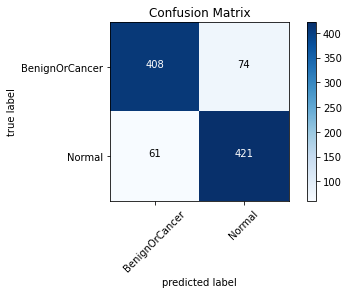

In [26]:
cm_plot_labels = CAT
plot_confusion_matrix(cm=cm,classes=cm_plot_labels, title='Confusion Matrix')

In [27]:
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

31/31 [==============================] - 1s 20ms/step - loss: 0.2979 - accuracy: 0.8600
accuracy: 86.00%


In [28]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_preds = model.predict(X_test).ravel()
fpr,tpr,thresholds = roc_curve(y_test,y_preds)
plt.figure(1)
plt.plot([0,1],[0,1],'y--')
plt.plot(fpr,tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

ValueError: multilabel-indicator format is not supported

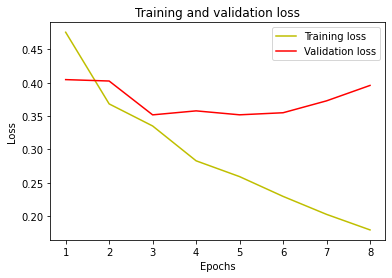

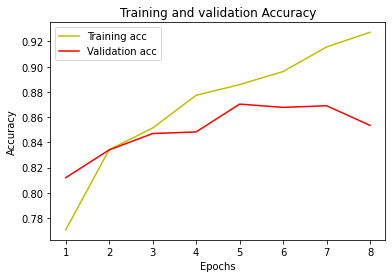

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss,'y', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs,acc,'y', label = "Training acc")
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title("Training and validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()